# `CLOUD.jl` - 1D linear advection-diffusion example

In [31]:
using CLOUD, OrdinaryDiffEq, Plots

Define the physical problem

In [32]:
a = 1.0  # wave speed
b = 1.0e-3  # diffusion coefficient

A = 1.0  # amplitude
L = 1.0  # domain length
σ = 0.1  # width of Gaussian pulse
x₀ = 0.5  # centre of Gaussian pulse
T = 1.0  # end time for one period

initial_data = InitialDataGaussian(A,σ,x₀)
conservation_law = LinearAdvectionDiffusionEquation(a,b)
exact_solution = ExactSolution(conservation_law,initial_data,periodic=true);

Set discretization parameters

In [33]:
M = 10
p = 6
form = WeakConservationForm()
strategy = Lazy()

ode_algorithm = CarpenterKennedy2N54()
dt = 0.1*(L/M)/(a*(2*p+1));
write_interval = floor(Int, T/(dt*10));

Set up a `DGSEM` scheme with LGL quadrature of degree `p` with `M` elements

In [34]:
reference_approximation =ReferenceApproximation(
    DGSEM(p), Line(), volume_quadrature_rule=LGLQuadrature())

mesh = uniform_periodic_mesh(
    reference_approximation.reference_element, (0.0,L), M)

spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation)

results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, (0.0, T), Lazy(),
     "results/advection_diffusion_1d_dgsem/", overwrite=true, clear=true);

Run the solver and plot the solution

In [35]:
ode_problem = semidiscretize(conservation_law,
    spatial_discretization,
    initial_data, 
    form,
    (0.0, T),
    strategy)
save_solution(ode_problem.u0, 0.0, results_path, 0)
CLOUD_reset_timer()
sol = solve(ode_problem, ode_algorithm, adaptive=false, dt=dt,
    save_everystep=false, callback=save_callback(results_path, write_interval))
CLOUD_print_timer()

save_solution(last(sol.u), last(sol.t), results_path, "final")

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:          201μs / 605308.0%        25.5KiB / 2087551.2%  

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 primary variable       65.1k    748ms   61.4%  11.5μs    322MiB   62.0%  5.06KiB
   eval visc num flux   65.1k    238ms   19.6%  3.67μs   60.6MiB   11.7%     976B
   apply operators      65.1k    196ms   16.1%  3.01μs   78.4MiB   15.1%  1.23KiB
     volume terms       65.1k   45.2ms    3.7%   694ns   23.8MiB    4.6%     384B
     mass matrix solve  65.1k   25.2ms    2.1%   387ns   13.9MiB    2.7%     224B
     facet terms        65.1k   18.5ms    1.5%   284ns   4.96MiB    1.0%    80.0B
   eval flux   

Calculate the integral L<sup>2</sup> error norm and conservation/energy error

In [36]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)

println("L2 error:")
println(analyze(error_analysis, last(sol.u), exact_solution, T)...)
println("Conservation (initial/final/diff):")
println(analyze(conservation_analysis)...)
println("Energy (initial/final/diff):")
println(analyze(energy_analysis)...)

L2 error:
3.930244910307679e-6
Conservation (initial/final/diff):
[0.25066268375731177][0.2506626837573158][4.052314039881821e-15]
Energy (initial/final/diff):
[0.08862269253878123][0.08090107976979288][-0.007721612768988348]


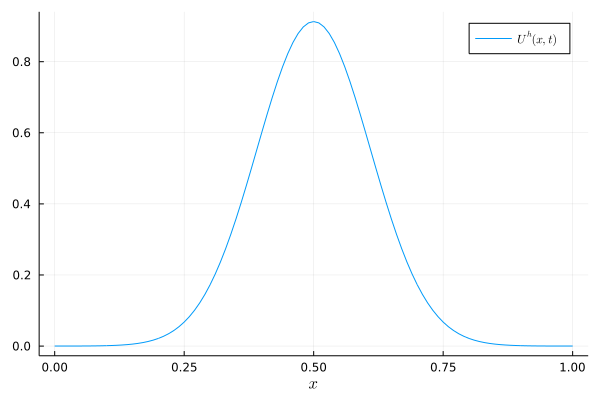

In [48]:
plot(spatial_discretization, last(sol.u))